# Data Analysis 1 - Optimization on ArmV8

## Section 1: File Parsing

### Section 1.1: Reading Log Files

In [1]:
import os
import pandas as pd
import seaborn as sns
import sys 
sys.path.append('/home/zhouzikai/nn_ext_dataflows/data_analysis')
from scripts import build_dataframe
import re


BASELINE_DIR = '/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3'
EXTENDED_DIR = '/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log'

def parse_filename_bl(filename):
    pattern = r"([a-z]{2})_([0-9a-zA-Z]+)_baseline_(\d+)_hw_(\d+)_f_(\d+)_nf_(\d+)_s_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        return {
            'anchoring_stationary': match.group(1),
            'num_bits': num_bits,
            'vector_length': int(match.group(3)),
            'input_hw': int(match.group(4)),
            'filter_size': int(match.group(5)),
            'num_filters': int(match.group(6)),
            'stride': int(match.group(7)),
            'cpu_type': match.group(8),
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)

def get_data_size_df_bl(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_bl(filename)
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

def append_dataframe(df1, df2, join_keyword='filename'):
    '''
    add the 'size' column from df1 to df2, assuming their indices are the same (file path)
    '''
    merged_df = df2.join(df1)

    return merged_df


def parse_filename_ex(filename):
    pattern = r"vl(\d+)_([0-9a-zA-Z]+)_stride_(\d+)_fs_(\d+)_([a-z]{2})((?:_[a-zA-Z]+_\d+)+)_hw_(\d+)_nf_(\d+)_(\w+)CPU__stats"
    match = re.match(pattern, filename)

    if match:
        num_bits = match.group(2)
        if num_bits == 'bin':
            num_bits = 1
        elif num_bits == '8bt':
            num_bits = 8
        else:
            raise Exception("number of bits not hardcoded")
            num_bits = int(num_bits)

        # Parsing and sorting auxiliary stationary and stats pairs
        aux_pairs_str = match.group(6)
        aux_pairs = re.findall(r"_([a-zA-Z]+)_(\d+)", aux_pairs_str)
        sorted_aux_pairs = sorted(aux_pairs, key=lambda x: (x[0], int(x[1])))

        aux_data = {}
        for i, (name, value) in enumerate(sorted_aux_pairs):
            if name not in aux_data:
                aux_data[f'aux_{name}'] = int(value)
            else:
                aux_data[f'aux_{name}_{i + 1}'] = int(value)

        return {
            'vector_length': int(match.group(1)),
            'num_bits': num_bits,
            'stride': int(match.group(3)),
            'filter_size': int(match.group(4)),
            'anchoring_stationary': match.group(5),
            'input_hw': int(match.group(7)),
            'num_filters': int(match.group(8)),
            'cpu_type': match.group(9),
            **aux_data
        }
    else:
        print(f"unmatched. filename: {filename}")
        return {}
def get_file_size(file_path):
    return os.path.getsize(file_path)


def get_data_size_df_ex(directory):
    file_data = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        parsed_info = parse_filename_ex(filename)
        # if (get_file_size(f)) == 0:
        #     # print("found one empty")
        file_data.append({'file_path': f, 'size': get_file_size(f), **parsed_info})
    df = pd.DataFrame(file_data).set_index('file_path')
    return df

# Read Baseline Directory
df_bl = get_data_size_df_bl(BASELINE_DIR)
bl_file_list=[]
for filename in os.listdir(BASELINE_DIR):
   f = os.path.join(BASELINE_DIR, filename)
   bl_file_list.append(f)
df_bl_files = build_dataframe(bl_file_list)
df_bl= append_dataframe(df_bl,df_bl_files)

# Read Extended Directory
df_ex = get_data_size_df_ex(EXTENDED_DIR)
ex_file_list=[]
for filename in os.listdir(EXTENDED_DIR):
   f = os.path.join(EXTENDED_DIR, filename)
   ex_file_list.append(f)
df_ex_files = build_dataframe(ex_file_list)
df_ex= append_dataframe(df_ex,df_ex_files)
df_ex_ana = df_ex

In [2]:
filename = "vl512_8bt_stride_1_fs_3_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt"
result = parse_filename_ex(filename)
print(result)

{'vector_length': 512, 'num_bits': 8, 'stride': 1, 'filter_size': 3, 'anchoring_stationary': 'ws', 'input_hw': 112, 'num_filters': 8, 'cpu_type': 'ArmO3', 'aux_is': 5, 'aux_os': 0}


In [3]:
df_ex

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters,cpu_type,aux_os,aux_ws,aux_is
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.002352,2.352289e+09,2.352289e+09,1.000000e+12,37.30,63070959.0,681144.0,10057646.0,12345525.0,269671.0,...,8,2,4,is,56,8,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_4_ws_os_0_is_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.025362,2.536167e+10,2.635202e+10,1.000000e+12,95.92,264408250.0,680120.0,10838880.0,13076502.0,113001.0,...,8,2,4,ws,112,8,ArmO3,0.0,NaN,5.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_2_fs_4_os_ws_5_is_8_hw_56_nf_16_ArmO3CPU__stats.txt,0.000347,3.473805e+08,1.337178e+09,1.000000e+12,7.55,46030219.0,680120.0,3538547.0,4241953.0,468872.0,...,8,2,4,os,56,16,ArmO3,NaN,5.0,8.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_1_fs_5_os_ws_5_is_0_hw_56_nf_32_ArmO3CPU__stats.txt,0.013565,1.356541e+10,1.455434e+10,1.000000e+12,259.25,52324606.0,680120.0,43988994.0,71331706.0,169675.0,...,8,1,5,os,56,32,ArmO3,NaN,5.0,0.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_8bt_stride_2_fs_5_os_ws_0_is_5_hw_56_nf_8_ArmO3CPU__stats.txt,0.001321,1.321344e+09,2.311426e+09,1.000000e+12,19.25,68626619.0,680120.0,4519972.0,7311776.0,234752.0,...,8,2,5,os,56,8,ArmO3,NaN,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_bin_stride_2_fs_5_os_ws_13_is_0_hw_56_nf_16_ArmO3CPU__stats.txt,0.000811,8.106230e+08,1.800217e+09,1.000000e+12,19.74,41063870.0,680124.0,6989825.0,8526483.0,354082.0,...,1,2,5,os,56,16,ArmO3,NaN,13.0,0.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl256_8bt_stride_1_fs_5_os_ws_0_is_13_hw_56_nf_8_ArmO3CPU__stats.txt,0.001619,1.619145e+09,2.608906e+09,1.000000e+12,19.25,84102201.0,680120.0,6136026.0,7670229.0,318717.0,...,8,1,5,os,56,8,ArmO3,NaN,0.0,13.0
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_2_fs_4_is_ws_0_os_5_hw_56_nf_32_ArmO3CPU__stats.txt,0.008858,8.857878e+09,8.857878e+09,1.000000e+12,142.73,62060786.0,681140.0,43660251.0,51996736.0,305896.0,...,1,2,4,is,56,32,ArmO3,5.0,0.0,NaN
/home/zhouzikai/nn_ext_dataflows/gen_programs/noblock/log/vl512_bin_stride_1_fs_3_is_ws_0_os_5_hw_112_nf_8_ArmO3CPU__stats.txt,0.011117,1.111731e+10,1.111731e+10,1.000000e+12,89.94,123613505.0,681140.0,20395374.0,25352869.0,226776.0,...,1,1,3,is,112,8,ArmO3,5.0,0.0,NaN


In [4]:
df_bl

,simSeconds,simTicks,finalTick,simFreq,hostSeconds,hostTickRate,hostMemory,simInsts,simOps,hostInstRate,...,system.mem_ctrls.rdPerTurnAround::896-1023,size,anchoring_stationary,num_bits,vector_length,input_hw,filter_size,num_filters,stride,cpu_type
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,5.664908e+10,5.664908e+10,1.000000e+12,280.72,201802520.0,681144.0,42124919.0,42396496.0,150063.0,...,NaN,172399,ws,1,128,112,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,4.103061e+09,4.103061e+09,1.000000e+12,53.96,76038771.0,681144.0,21393754.0,21665456.0,396472.0,...,NaN,172141,os,1,128,56,4,16,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,1.398118e+10,1.398118e+10,1.000000e+12,92.45,151236364.0,681140.0,18554340.0,21032824.0,200705.0,...,NaN,172265,ws,1,512,56,3,64,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,4.713684e+10,4.713684e+10,1.000000e+12,242.88,194071399.0,681140.0,37855927.0,38127504.0,155860.0,...,NaN,172137,ws,1,128,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,1.415693e+10,1.415693e+10,1.000000e+12,147.49,95987469.0,681144.0,43321281.0,55780535.0,293729.0,...,NaN,171877,os,8,512,112,5,16,2,ArmO3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,2.511420e+10,2.511420e+10,1.000000e+12,173.58,144682786.0,681144.0,50598563.0,50870169.0,291498.0,...,NaN,172394,is,1,128,56,3,64,1,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,1.388558e+09,1.388558e+09,1.000000e+12,15.11,91923314.0,680116.0,4460928.0,4732103.0,295313.0,...,NaN,171734,os,8,128,56,3,16,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,5.776026e+10,5.776026e+10,1.000000e+12,331.96,174000023.0,681144.0,61456501.0,69615596.0,185135.0,...,NaN,172013,ws,1,512,112,4,32,2,ArmO3
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,1.793547e+09,1.793547e+09,1.000000e+12,19.46,92150946.0,681144.0,5166835.0,6405958.0,265466.0,...,NaN,171874,os,8,512,56,4,8,2,ArmO3


In [5]:
len(df_bl)

864

In [6]:
len(df_ex)

1489

### Section 2.2: Filtering to Useful Columns Only

In [7]:
COL_FILTER = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters"]

REF_COLS = ["simSeconds","simInsts","simOps","vector_length","num_bits","stride","filter_size","anchoring_stationary","input_hw","num_filters","system.cpu.dcache.demandMissRate::cpu.data","system.cpu.dcache.demandAvgMissLatency::total","system.cpu.dcache.writebacks::total","system.mem_ctrls.dram.numReads::cpu.data","system.mem_ctrls.dram.numWrites::total"]

df_bl = df_bl[COL_FILTER]
df_ex = df_ex[COL_FILTER]

In [8]:
df_ex = df_ex.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"]).min()

In [9]:
df_bl

,simSeconds,simInsts,simOps,vector_length,num_bits,stride,filter_size,anchoring_stationary,input_hw,num_filters
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.056649,42124919.0,42396496.0,128,1,2,3,ws,112,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_bin_baseline_128_hw_56_f_4_nf_16_s_1_ArmO3CPU__stats.txt,0.004103,21393754.0,21665456.0,128,1,1,4,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_56_f_3_nf_64_s_2_ArmO3CPU__stats.txt,0.013981,18554340.0,21032824.0,512,1,2,3,ws,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_128_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.047137,37855927.0,38127504.0,128,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_112_f_5_nf_16_s_2_ArmO3CPU__stats.txt,0.014157,43321281.0,55780535.0,512,8,2,5,os,112,16
...,...,...,...,...,...,...,...,...,...,...
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/is_bin_baseline_128_hw_56_f_3_nf_64_s_1_ArmO3CPU__stats.txt,0.025114,50598563.0,50870169.0,128,1,1,3,is,56,64
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_128_hw_56_f_3_nf_16_s_2_ArmO3CPU__stats.txt,0.001389,4460928.0,4732103.0,128,8,2,3,os,56,16
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/ws_bin_baseline_512_hw_112_f_4_nf_32_s_2_ArmO3CPU__stats.txt,0.057760,61456501.0,69615596.0,512,1,2,4,ws,112,32
/home/zhouzikai/nn_ext_dataflows/baselines/log_ArmO3/os_8bt_baseline_512_hw_56_f_4_nf_8_s_2_ArmO3CPU__stats.txt,0.001794,5166835.0,6405958.0,512,8,2,4,os,56,8


In [10]:
df_ex

simSeconds   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      0.001337  \
                                                               os                      0.000399   
                                                               ws                      0.000556   
                                                   16          is                      0.002862   
                                                               os                      0.001628   
...                                                                                         ...   
512           8        2      5           112      32          os                      0.024336   
                                                               ws                      0.158371   
                                                   64          is                      0.092820   
                                                               os                      0.049273   
                                                               ws                      0.318073   

                                                                                        simInsts   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                
128           1        1      3           56       8           is                      3516983.0  \
                                                               os                      3052265.0   
                                                               ws                      3291910.0   
                                                   16          is                      5366576.0   
                                                               os                      4447250.0   
...                                                                                          ...   
512           8        2      5           112      32          os                     45559569.0   
                                                               ws                     58990644.0   
                                                   64          is                    468663962.0   
                                                               os                     89461801.0   
                                                               ws                    116323980.0   

                                                                                          simOps  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3788095.0  
                                                               os                      3321413.0  
                                                               ws                      3682103.0  
                                                   16          is                      5637768.0  
                                                               os                      4716462.0  
...                                                                                          ...  
512           8        2      5           112      32          os                     81436901.0  
                                                               ws                     71564876.0  
                                                   64          is                    570282877.0  
                                                               os                    160947422.0  
                                                               ws                    141203365.0  

[843 rows x 3 columns]

### Section 2.3: Merging baseline and optimized dataframes

In [11]:
df_ex = df_ex.rename(columns={"simSeconds":"simSeconds_opt","simInsts":"simInsts_opt","simOps":"simOps_opt"})
df_merged = pd.merge(df_ex,df_bl,how='left',\
                    left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"],\
                    right_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',"anchoring_stationary"])

In [12]:
NUM_FILTER_LOWER = 16
NUM_FILTER_UPPER = 64
VEC_LEN_LIST = [128,256,512]

In [13]:
df_merged

,vector_length,num_bits,stride,filter_size,input_hw,num_filters,anchoring_stationary,simSeconds_opt,simInsts_opt,simOps_opt,simSeconds,simInsts,simOps
0,128,1,1,3,56,8,is,0.001337,3516983.0,3788095.0,0.002728,7786158.0,8057764.0
1,128,1,1,3,56,8,os,0.000399,3052265.0,3321413.0,0.001901,7649254.0,7920915.0
2,128,1,1,3,56,8,ws,0.000556,3291910.0,3682103.0,0.002117,6695706.0,6967312.0
3,128,1,1,3,56,16,is,0.002862,5366576.0,5637768.0,0.006385,13902231.0,14173837.0
4,128,1,1,3,56,16,os,0.001628,4447250.0,4716462.0,0.003189,13628103.0,13899772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,512,8,2,5,112,32,os,0.024336,45559569.0,81436901.0,0.027347,84974677.0,109622091.0
839,512,8,2,5,112,32,ws,0.158371,58990644.0,71564876.0,0.084633,82078547.0,94541802.0
840,512,8,2,5,112,64,is,0.092820,468663962.0,570282877.0,0.166654,697579241.0,800077569.0
841,512,8,2,5,112,64,os,0.049273,89461801.0,160947422.0,0.053818,168281642.0,217305409.0


In [14]:
df_merged = df_merged[(df_merged["num_filters"]>= NUM_FILTER_LOWER) &(df_merged["num_filters"]<= NUM_FILTER_UPPER)& (df_merged["vector_length"].isin(VEC_LEN_LIST)) & (df_merged["stride"]==1)]

<Axes: xlabel='simSeconds'>

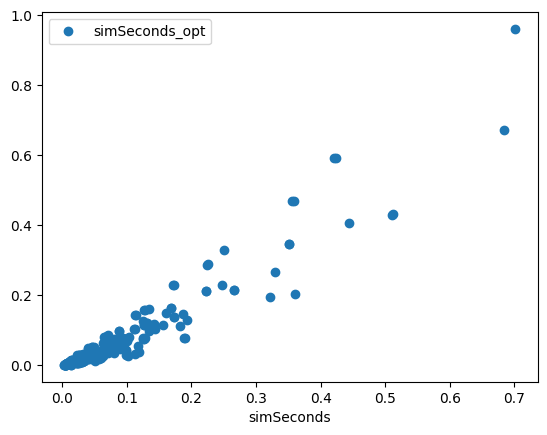

In [15]:
df_merged.plot(x="simSeconds",y="simSeconds_opt",style=['o','rx'])

## Section 2: Calculating Improvments

In [16]:
df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]

/tmp/ipykernel_963008/1120125696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["improvement"] = df_merged["simSeconds"]/df_merged["simSeconds_opt"]


(array([ 0.,  0.,  4., 34., 53., 56., 55., 38., 31., 13.,  4., 10.,  3.,
         3.,  2.,  3.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

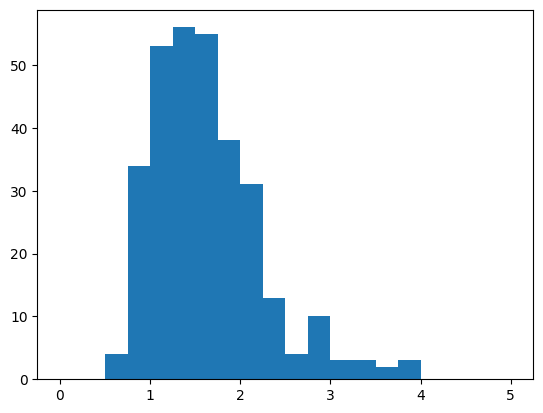

In [17]:
import matplotlib.pyplot as plt

plt.hist(df_merged['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  0.,  0., 30., 29.,  5., 11., 12.,  4.,  8.,  3.,
         3.,  2.,  1.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

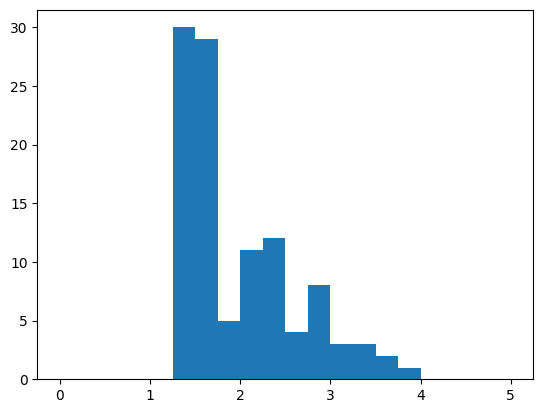

In [18]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='is']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  0.,  6., 16., 16., 19., 30., 20.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

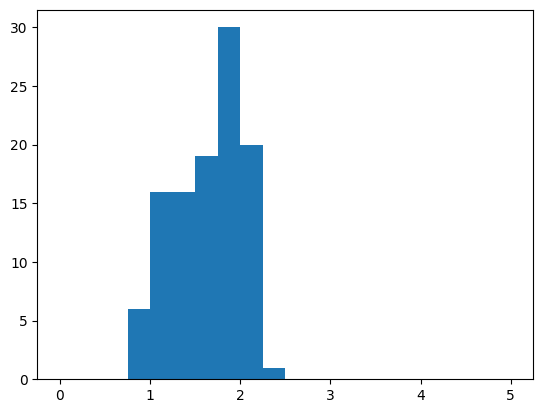

In [19]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='os']['improvement'], range=[0, 5],bins=20)

(array([ 0.,  0.,  4., 28., 37., 10.,  7.,  3.,  0.,  0.,  0.,  2.,  0.,
         0.,  0.,  2.,  0.,  0.,  0.,  0.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <BarContainer object of 20 artists>)

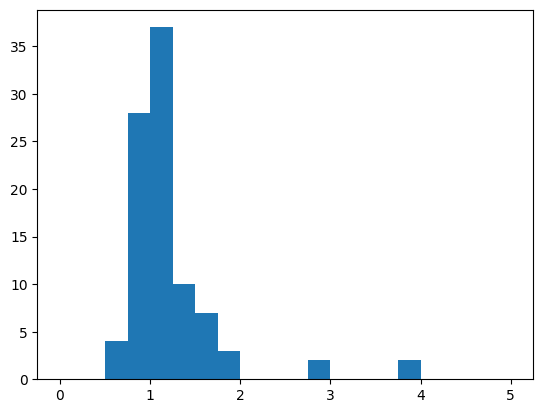

In [20]:
plt.hist(df_merged[df_merged["anchoring_stationary"]=='ws']['improvement'], range=[0, 5],bins=20)

In [21]:
df_merged['improvement'].mean()

1.660046313058907

In [22]:
df_merged['improvement'].median()

1.5476224322979601

In [23]:
len(df_merged["vector_length"]==128)

311

In [24]:
len(df_merged["vector_length"]==256)

311

In [25]:
len(df_merged["vector_length"]==512)

311

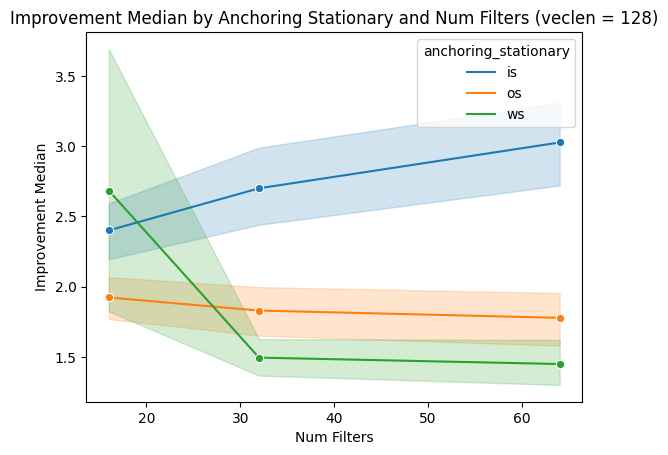

In [26]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits","input_hw","simSeconds_opt","filter_size"])["improvement"].median().reset_index()
sns.lineplot(data=grouped_df[(grouped_df["vector_length"]==128)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 128)'
)
plt.show()

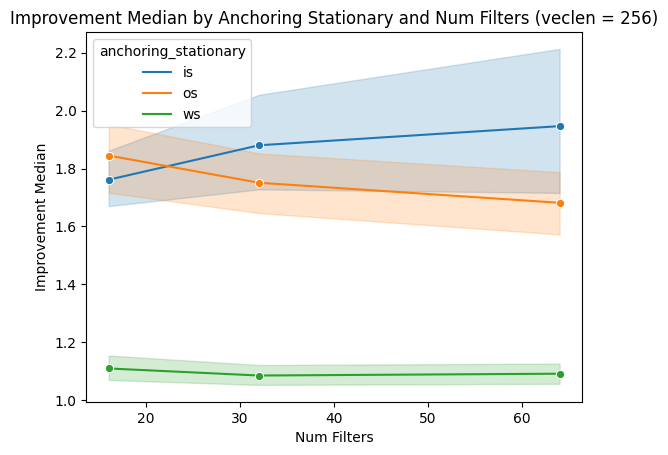

In [27]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==256], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 256)'
)
plt.show()

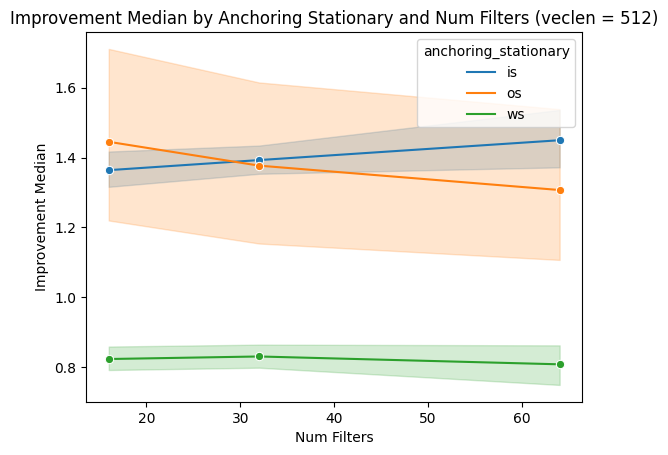

In [28]:
sns.lineplot(data=grouped_df[grouped_df["vector_length"]==512], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (veclen = 512)'
)
plt.show()

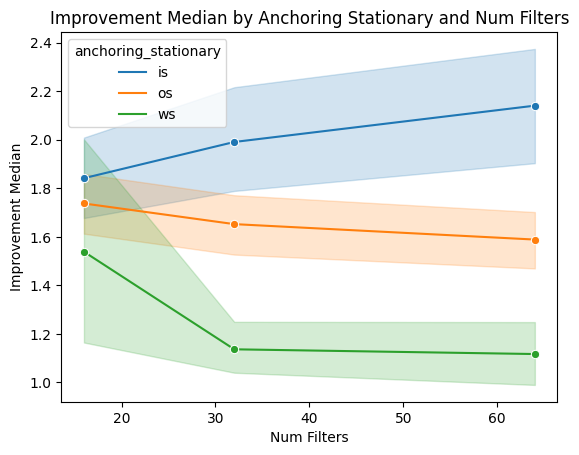

In [29]:
sns.lineplot(data=grouped_df, x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters'
)
plt.show()

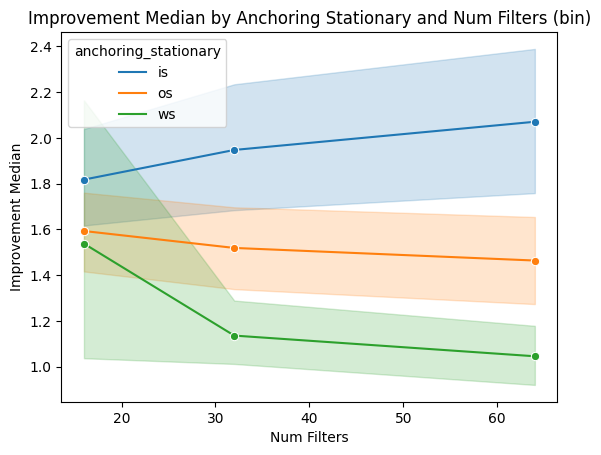

In [30]:

sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (bin)'
)
plt.show()

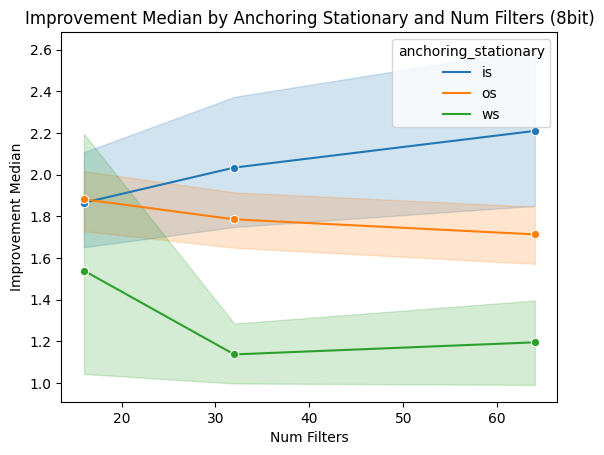

In [31]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit)'
)
plt.show()

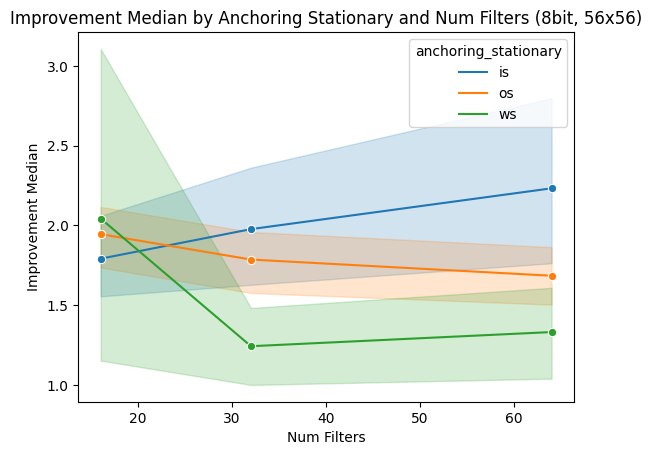

In [32]:

sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8) & (grouped_df["input_hw"]==56)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit, 56x56)'
)
plt.show()

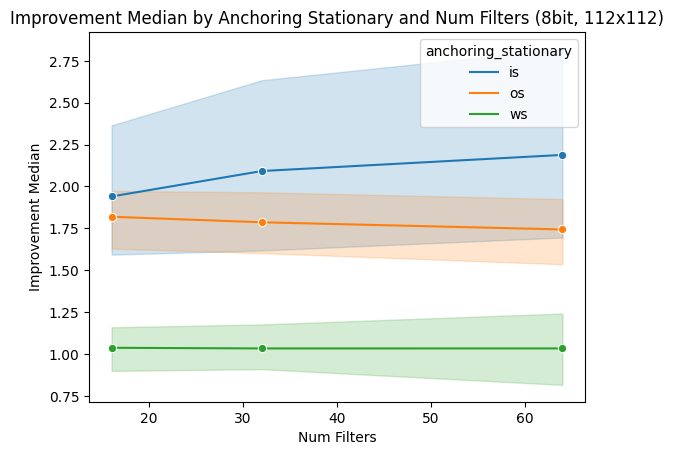

In [33]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8) & (grouped_df["input_hw"]==112)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (8bit, 112x112)'
)
plt.show()

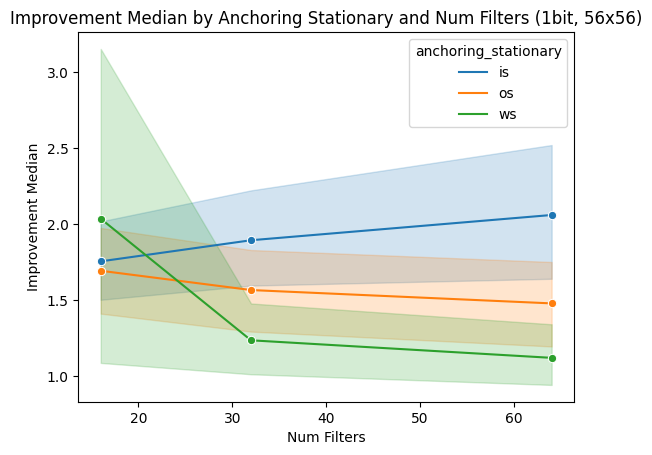

In [34]:

sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1) & (grouped_df["input_hw"]==56)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (1bit, 56x56)'
)
plt.show()

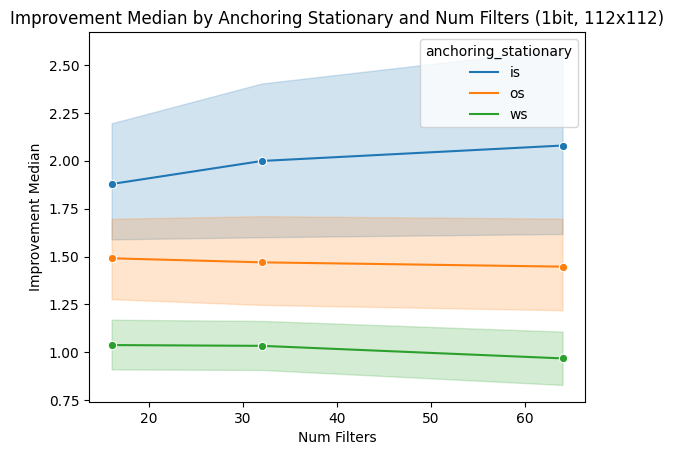

In [35]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1) & (grouped_df["input_hw"]==112)], x='num_filters', y='improvement', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Improvement Median')
plt.title('Improvement Median by Anchoring Stationary and Num Filters (1bit, 112x112)'
)
plt.show()

In [36]:
grouped_df = df_merged.groupby(["anchoring_stationary","num_filters","vector_length","num_bits","input_hw","simSeconds_opt","filter_size"])["improvement"].mean().reset_index()

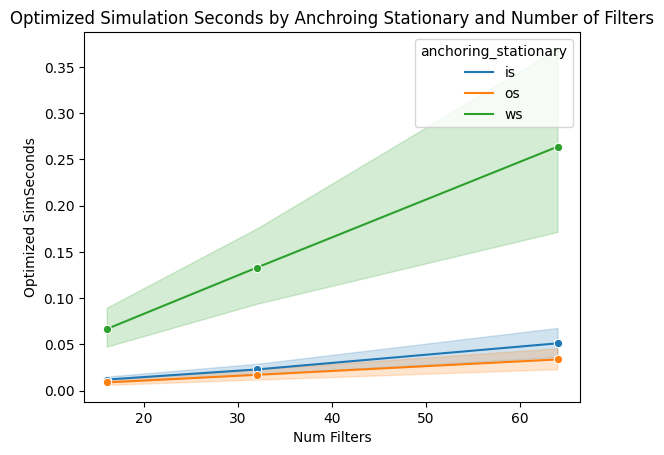

In [37]:
sns.lineplot(data=grouped_df, x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters'
)
plt.show()

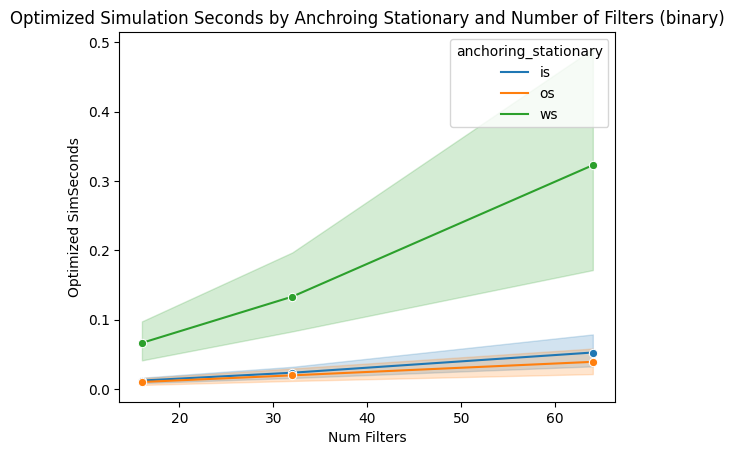

In [38]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==1], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary)'
)
plt.show()

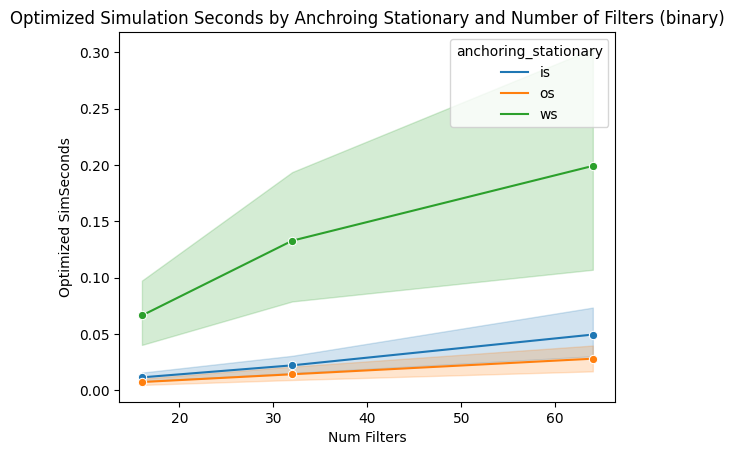

In [39]:
sns.lineplot(data=grouped_df[grouped_df["num_bits"]==8], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary)'
)
plt.show()

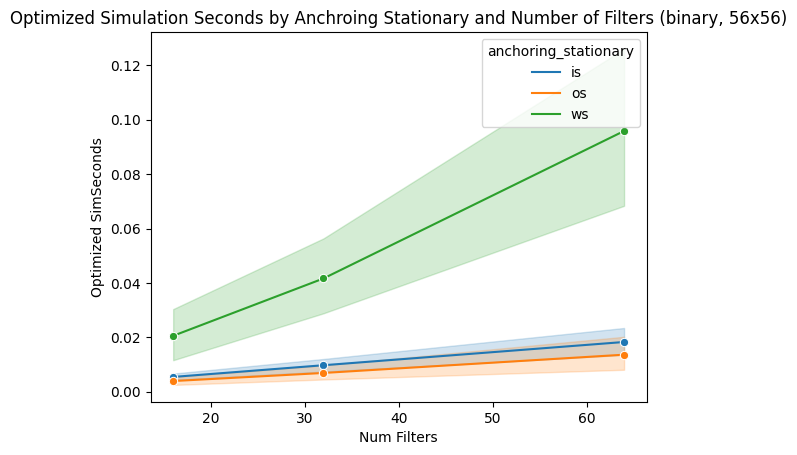

In [40]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1)&(grouped_df["input_hw"]==56)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary, 56x56)'
)
plt.show()

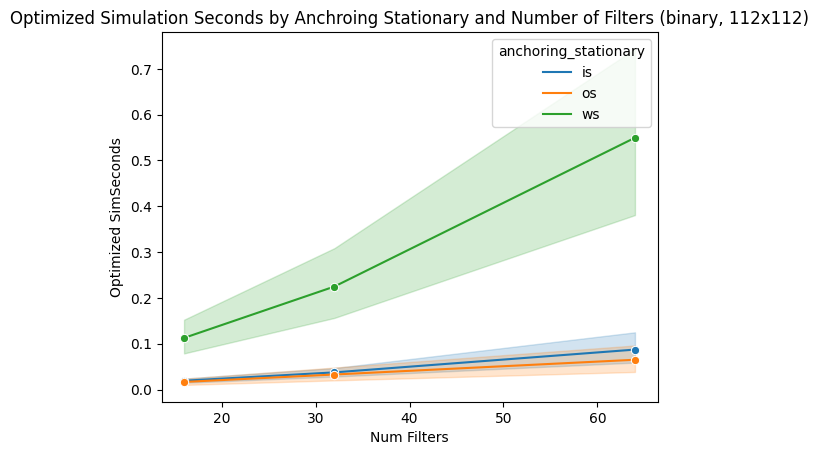

In [41]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==1)&(grouped_df["input_hw"]==112)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (binary, 112x112)'
)
plt.show()

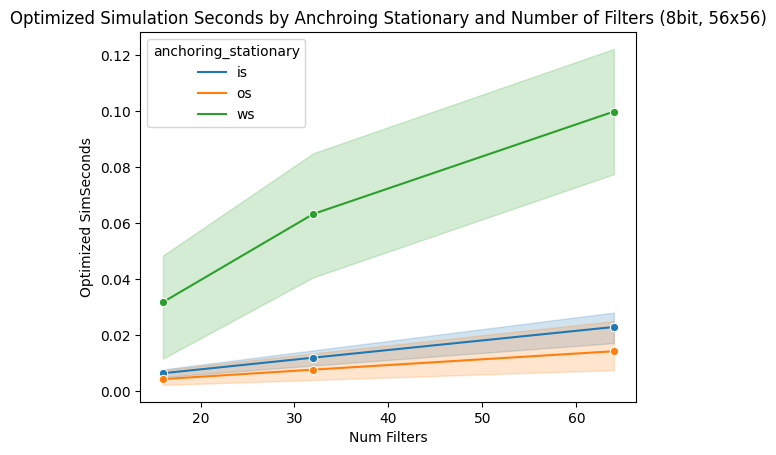

In [42]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8)&(grouped_df["input_hw"]==56)&(grouped_df["filter_size"]==5)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (8bit, 56x56)'
)
plt.show()

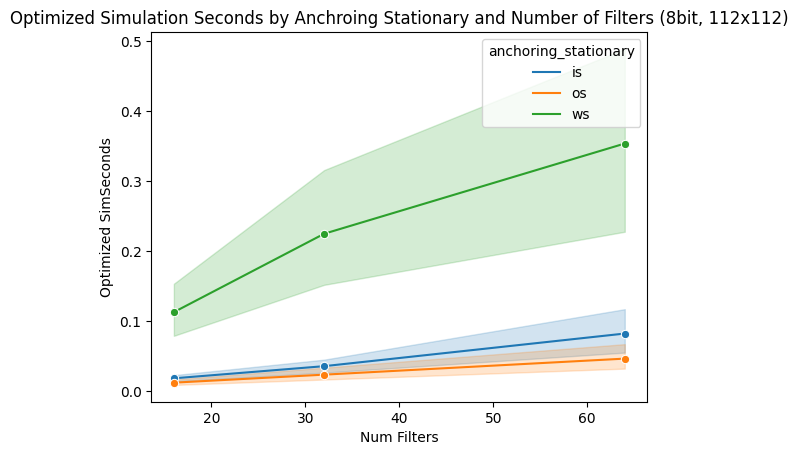

In [43]:
sns.lineplot(data=grouped_df[(grouped_df["num_bits"]==8)&(grouped_df["input_hw"]==112)], x='num_filters', y='simSeconds_opt', hue='anchoring_stationary', marker='o')
plt.xlabel('Num Filters')
plt.ylabel('Optimized SimSeconds')
plt.title('Optimized Simulation Seconds by Anchroing Stationary and Number of Filters (8bit, 112x112)'
)
plt.show()

In [44]:
grouped_df

,anchoring_stationary,num_filters,vector_length,num_bits,input_hw,simSeconds_opt,filter_size,improvement
0,is,16,128,1,56,0.002862,3,2.230957
1,is,16,128,1,56,0.003409,4,2.375770
2,is,16,128,1,56,0.005165,5,2.095063
3,is,16,128,1,112,0.008656,3,2.646026
4,is,16,128,1,112,0.011130,4,2.661995
...,...,...,...,...,...,...,...,...
306,ws,64,512,1,112,0.961062,5,0.729802
307,ws,64,512,8,56,0.053176,3,0.936024
308,ws,64,512,8,56,0.098105,4,0.890250
309,ws,64,512,8,112,0.330468,3,0.756712


In [45]:
def calculate_is_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    return (ws_value - is_value) / is_value

def calculate_os_ws_difference(group):
    ws_value = group.loc[group['anchoring_stationary'] == 'ws', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (ws_value - os_value) / os_value


def calculate_is_os_difference(group):
    is_value = group.loc[group['anchoring_stationary'] == 'is', 'simSeconds_opt'].min()
    os_value = group.loc[group['anchoring_stationary'] == 'os', 'simSeconds_opt'].min()
    return (is_value - os_value) / os_value

In [46]:
is_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_ws_difference).reset_index(name='is_ws_difference')

os_ws_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_os_ws_difference).reset_index(name='os_ws_difference')

is_os_diff = df_merged.groupby(['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters']).apply(calculate_is_os_difference).reset_index(name='is_os_difference')

<Axes: >

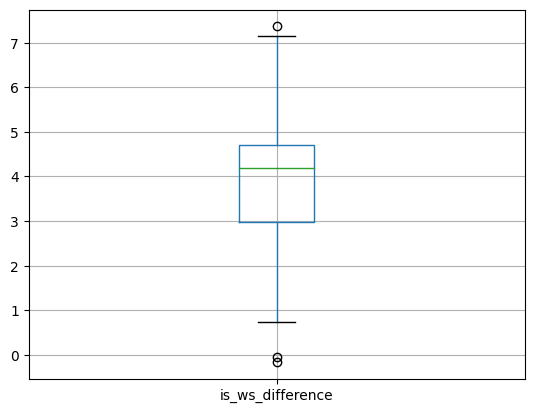

In [47]:
is_ws_diff.boxplot(column="is_ws_difference")

<Axes: >

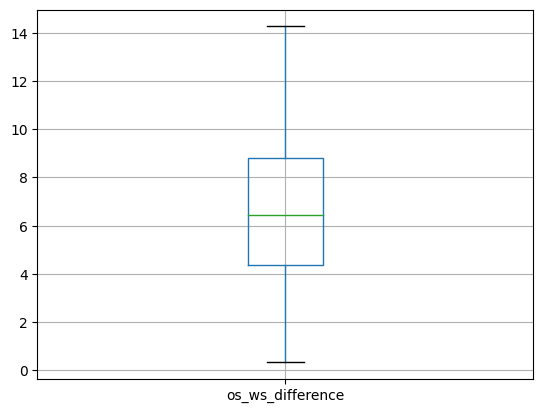

In [48]:
os_ws_diff.boxplot(column="os_ws_difference")

<Axes: >

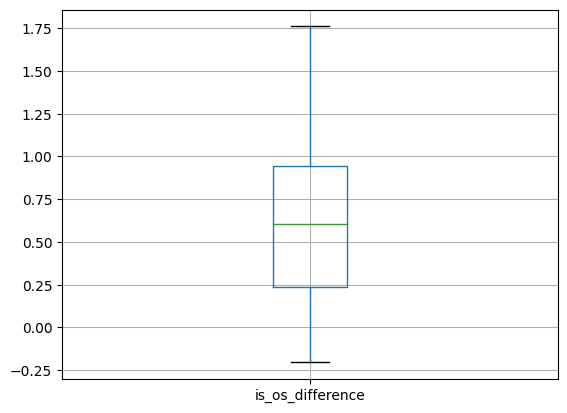

In [49]:
is_os_diff.boxplot(column="is_os_difference")

In [50]:
len(is_os_diff[is_os_diff["is_os_difference"]<=0])/len(is_os_diff[is_os_diff["is_os_difference"].notna()])

0.09259259259259259

### Analyzing Baselines

In [51]:
df_bl_is = df_bl[df_bl["anchoring_stationary"]=="is"]
df_bl_os = df_bl[df_bl["anchoring_stationary"]=="os"]
df_bl_ws = df_bl[df_bl["anchoring_stationary"]=="ws"]

In [52]:
df_bl_is = df_bl_is.rename(columns={"simSeconds":"simSeconds_is","simInsts":"simInsts_is","simOps":"simOps_is"})
df_bl_os = df_bl_os.rename(columns={"simSeconds":"simSeconds_os","simInsts":"simInsts_os","simOps":"simOps_os"})
df_bl_ws = df_bl_ws.rename(columns={"simSeconds":"simSeconds_ws","simInsts":"simInsts_ws","simOps":"simOps_ws"})

In [53]:
df_bl_db = pd.merge(df_bl_is,df_bl_os,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_db

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y
0,0.017861,67827612.0,73104275.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os
1,0.008540,31154349.0,33411072.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002639,8370379.0,9137945.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os


In [54]:
df_bl_tp = pd.merge(df_bl_db,df_bl_ws,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])
df_bl_tp

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,simSeconds_os,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary
0,0.017861,67827612.0,73104275.0,256,8,2,5,is,56,32,0.003716,17734332.0,20372914.0,os,0.006335,17080178.0,18536617.0,ws
1,0.008540,31154349.0,33411072.0,256,1,2,3,is,56,32,0.002488,8803833.0,9957343.0,os,0.004044,7907847.0,8620925.0,ws
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,0.003328,13433136.0,15225598.0,os,0.011012,12472358.0,13504604.0,ws
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,0.010226,58213276.0,65454626.0,os,0.048583,50525610.0,54283168.0,ws
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,0.037942,189695501.0,214973782.0,os,0.222222,174777531.0,187553428.0,ws
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002639,8370379.0,9137945.0,256,8,2,3,is,56,8,0.001280,3284963.0,3776576.0,os,0.001410,3062121.0,3443655.0,ws
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,0.009900,49167118.0,49438791.0,os,0.053352,41638683.0,41910260.0,ws
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,0.060581,432072062.0,432343156.0,os,0.510858,406092468.0,406363565.0,ws
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,0.019546,95683002.0,108457971.0,os,0.111791,88223768.0,94747505.0,ws


In [55]:
df_bl_tp["is_over_os"] = df_bl_tp["simSeconds_is"] / df_bl_tp["simSeconds_os"]
df_bl_tp["ws_over_os"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_os"]

<Axes: >

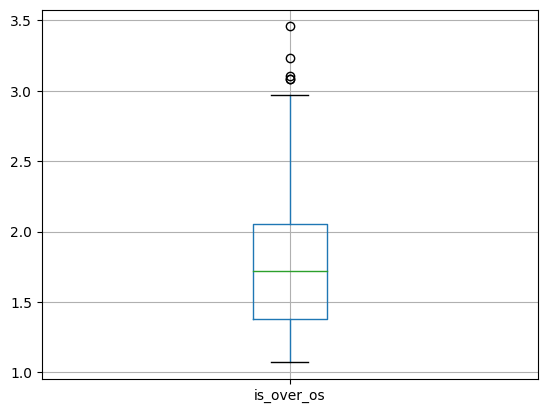

In [56]:
df_bl_tp[df_bl_tp["stride"]==1].boxplot(column="is_over_os")

In [57]:
df_bl_tp[df_bl_tp["stride"]==1]["is_over_os"].median()

1.7190344717283477

In [58]:
df_bl_tp[df_bl_tp["stride"]==2]["is_over_os"].median()

3.3313572595916963

In [59]:
df_bl_tp[df_bl_tp["stride"]==1]["ws_over_os"].median()

4.581050268735383

In [60]:
df_bl_tp[df_bl_tp["stride"]==2]["ws_over_os"].median()

2.630388501508683

<Axes: >

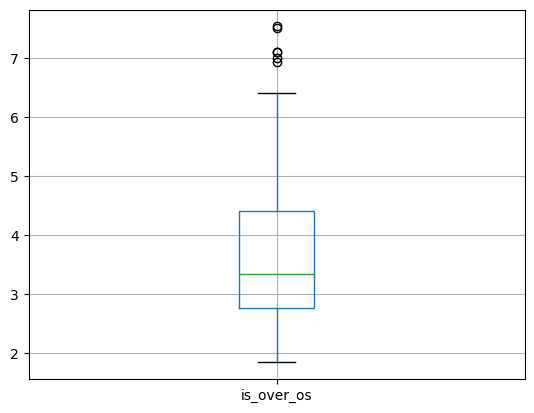

In [61]:
df_bl_tp[df_bl_tp["stride"]==2].boxplot(column="is_over_os")

In [62]:
len(df_bl_tp[df_bl_tp["is_over_os"]>=1])/len(df_bl_tp)

1.0

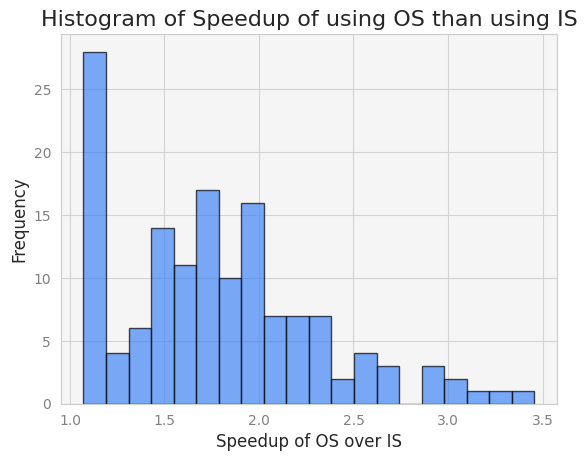

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plot style
sns.set_style("whitegrid")

# Filter the DataFrame
filtered_df = df_bl_tp[df_bl_tp["stride"] == 1]

# Define color and marker options
hist_color = "#4287f5"  # Blue color
marker = "o"  # Circle marker

# Plot the histogram
plt.hist(filtered_df["is_over_os"], bins=20, color=hist_color, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel("Speedup of OS over IS", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Histogram of Speedup of using OS than using IS", fontsize=16)

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a background color
plt.gca().set_facecolor('#f5f5f5')

plt.savefig("images/os_over_is_bl.png", dpi=300)
# Show the plot
plt.show()

In [64]:
df_bl_tp["ws_over_os"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_os"]

In [65]:
df_bl_tp["ws_over_is"] = df_bl_tp["simSeconds_ws"] / df_bl_tp["simSeconds_is"]

<Axes: >

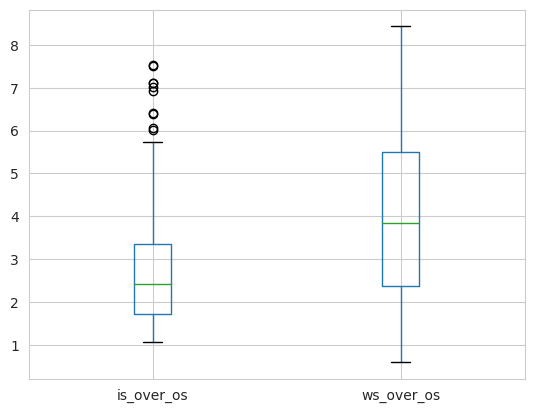

In [66]:
df_bl_tp.boxplot(column=["is_over_os","ws_over_os"])

In [67]:
df_bl_tp["ws_over_os"].median()

3.835969145434657

<Axes: >

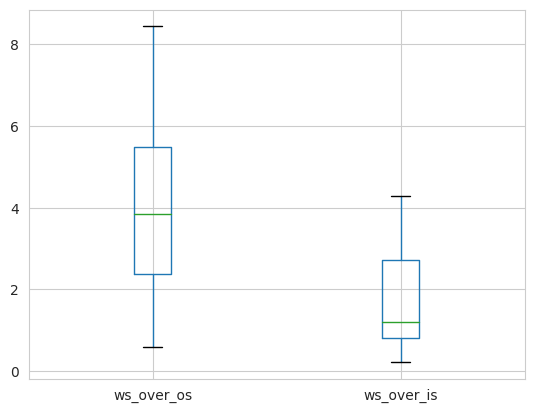

In [68]:
df_bl_tp.boxplot(column=["ws_over_os","ws_over_is"])

In [69]:
len(df_bl_tp[df_bl_tp["ws_over_os"]>=1])/len(df_bl_tp)

0.96875

In [70]:
len(df_bl_tp[df_bl_tp["ws_over_is"]>=1])/len(df_bl_tp)

0.6180555555555556

In [71]:
df_ex

simSeconds_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                   
128           1        1      3           56       8           is                          0.001337  \
                                                               os                          0.000399   
                                                               ws                          0.000556   
                                                   16          is                          0.002862   
                                                               os                          0.001628   
...                                                                                             ...   
512           8        2      5           112      32          os                          0.024336   
                                                               ws                          0.158371   
                                                   64          is                          0.092820   
                                                               os                          0.049273   
                                                               ws                          0.318073   

                                                                                     simInsts_opt   
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary                 
128           1        1      3           56       8           is                       3516983.0  \
                                                               os                       3052265.0   
                                                               ws                       3291910.0   
                                                   16          is                       5366576.0   
                                                               os                       4447250.0   
...                                                                                           ...   
512           8        2      5           112      32          os                      45559569.0   
                                                               ws                      58990644.0   
                                                   64          is                     468663962.0   
                                                               os                      89461801.0   
                                                               ws                     116323980.0   

                                                                                      simOps_opt  
vector_length num_bits stride filter_size input_hw num_filters anchoring_stationary               
128           1        1      3           56       8           is                      3788095.0  
                                                               os                      3321413.0  
                                                               ws                      3682103.0  
                                                   16          is                      5637768.0  
                                                               os                      4716462.0  
...                                                                                          ...  
512           8        2      5           112      32          os                     81436901.0  
                                                               ws                     71564876.0  
                                                   64          is                    570282877.0  
                                                               os                    160947422.0  
                                                               ws                    141203365.0  

[843 rows x 3 columns]

### Auxiliary Analysis

In [72]:
is_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="is"]
os_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="os"]
ws_anchored = df_ex_ana[df_ex_ana["anchoring_stationary"]=="ws"]

In [73]:
is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))

is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (is_anchored["aux_ws"] == 0))

os_anchored["prefer_ws"] = (os_anchored["aux_ws"] == os_anchored["filter_size"] * os_anchored["filter_size"])  | ((os_anchored["aux_is"] == 0) & (os_anchored["aux_ws"] > 0))

os_anchored["prefer_is"] = (os_anchored["aux_is"] != os_anchored["filter_size"] * (os_anchored["filter_size"] - os_anchored["stride"])) | ((os_anchored["aux_is"] > 0) & (os_anchored["aux_ws"] == 0))

ws_anchored["prefer_is"] = ws_anchored["aux_os"] == 0
ws_anchored["prefer_os"] = ws_anchored["aux_is"] == 0

/tmp/ipykernel_963008/1436946333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_ws"] = (is_anchored["aux_ws"] == is_anchored["filter_size"] * is_anchored["filter_size"]) | ((is_anchored["aux_os"] == 0) & (is_anchored["aux_ws"] > 0))
/tmp/ipykernel_963008/1436946333.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  is_anchored["prefer_os"] =(is_anchored["aux_os"] == is_anchored["filter_size"] * (is_anchored["filter_size"] - is_anchored["stride"])) | ((is_anchored["aux_os"] > 0) & (

In [74]:
df_is_aux = pd.merge(is_anchored[is_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),is_anchored[is_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_os_aux = pd.merge(os_anchored[os_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),os_anchored[os_anchored["prefer_ws"]].rename(columns={"simSeconds":"simSeconds_pws"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

df_ws_aux = pd.merge(ws_anchored[ws_anchored["prefer_is"]].rename(columns={"simSeconds":"simSeconds_pis"}),ws_anchored[ws_anchored["prefer_os"]].rename(columns={"simSeconds":"simSeconds_pos"}),how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [75]:
df_is_aux["ws_faster"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"]) < 0
df_os_aux["ws_faster"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"]) < 0
df_ws_aux["os_faster"]= (df_ws_aux["simSeconds_pos"] - df_ws_aux["simSeconds_pis"]) < 0

In [76]:
len(df_is_aux[df_is_aux["ws_faster"]]) / (len(df_is_aux[df_is_aux["ws_faster"]])+ len(df_is_aux[df_is_aux["ws_faster"]==False]))

0.22569444444444445

In [77]:
df_is_aux["os_faster"]= (df_is_aux["simSeconds_pos"] - df_is_aux["simSeconds_pws"]) < 0
df_is_aux["os_ws_same"] = (df_is_aux["simSeconds_pws"] == df_is_aux["simSeconds_pos"])
df_os_aux["is_os_same"] = (df_os_aux["simSeconds_pws"]==df_os_aux["simSeconds_pis"])
df_os_aux["is_faster"]= (df_os_aux["simSeconds_pis"] - df_os_aux["simSeconds_pws"]) < 0

In [78]:
len(df_is_aux[df_is_aux["os_faster"]]) / (len(df_is_aux[df_is_aux["os_faster"]])+ len((df_is_aux[(df_is_aux["os_faster"]==False)&(df_is_aux["os_ws_same"]==False)]) ))

0.6586538461538461

In [79]:
len(df_is_aux[df_is_aux["ws_faster"]]) / (len(df_is_aux[df_is_aux["ws_faster"]])+ len((df_is_aux[(df_is_aux["ws_faster"]==False)&(df_is_aux["os_ws_same"]==False)]) ))

0.3125

In [80]:
len(df_ws_aux[df_ws_aux["os_faster"]]) / (len(df_ws_aux[df_ws_aux["os_faster"]])+ len(df_ws_aux[df_ws_aux["os_faster"]==False]))

0.9057377049180327

In [81]:
df_is_aux["ws_faster_mag"]= (df_is_aux["simSeconds_pws"] - df_is_aux["simSeconds_pos"])/df_is_aux["simSeconds_pws"]
df_os_aux["ws_faster_mag"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"])/df_is_aux["simSeconds_pws"]

<Axes: >

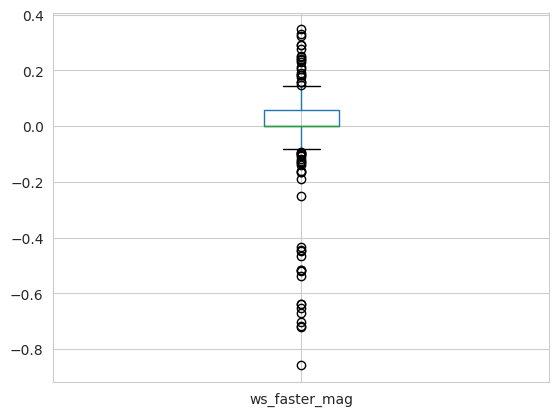

In [82]:
df_is_aux.boxplot(column="ws_faster_mag")

In [83]:
df_is_aux["os_faster"]

0      False
1      False
2       True
3       True
4      False
       ...  
283    False
284     True
285    False
286    False
287     True
Name: os_faster, Length: 288, dtype: bool

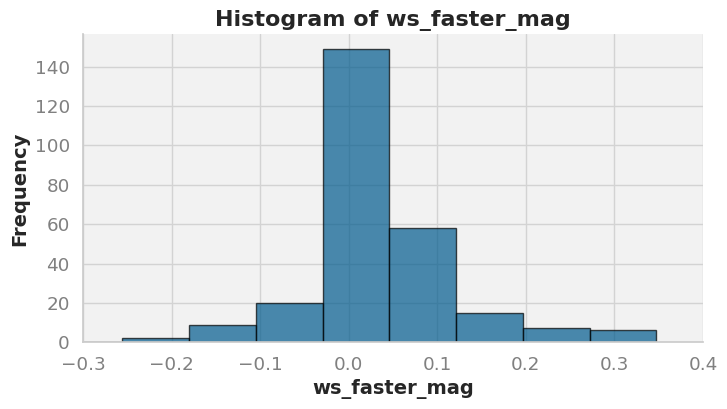

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a formal style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Plot the histogram
plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
plt.hist(df_is_aux["ws_faster_mag"], bins=16, color='#005a8d', edgecolor='black', alpha=0.7)
plt.xlim(-0.3,0.4)

# Add labels and title with formal styling
plt.xlabel("ws_faster_mag", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Histogram of ws_faster_mag", fontsize=16, fontweight='bold')

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a formal background color
plt.gca().set_facecolor('#f2f2f2')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the plot as a PNG image
plt.savefig("images/is_anchored_osvsws.png", dpi=300)

# Show the plot
plt.show()

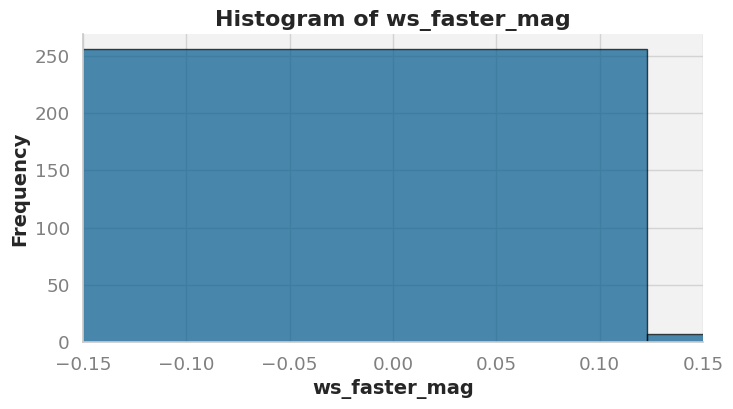

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a formal style using Seaborn
sns.set(style="whitegrid", font_scale=1.2)

# Plot the histogram
plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
plt.hist(df_os_aux["ws_faster_mag"], bins=18, color='#005a8d', edgecolor='black', alpha=0.7)
plt.xlim(-0.15,0.15)

# Add labels and title with formal styling
plt.xlabel("ws_faster_mag", fontsize=14, fontweight='bold')
plt.ylabel("Frequency", fontsize=14, fontweight='bold')
plt.title("Histogram of ws_faster_mag", fontsize=16, fontweight='bold')

# Customize grid and tick colors
plt.grid(color='lightgray')
plt.tick_params(colors='gray')

# Add a formal background color
plt.gca().set_facecolor('#f2f2f2')

# Remove the top and right spines
sns.despine(top=True, right=True)

# Save the plot as a PNG image
plt.savefig("images/os_anchored_isvsws.png", dpi=300)

# Show the plot
plt.show()

In [86]:
df_is_aux

,simSeconds_pws,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_os_y,ws_faster,os_faster,os_ws_same,ws_faster_mag
0,0.008590,8.589583e+09,8.589583e+09,1.000000e+12,80.56,106629916.0,681144.0,27193550.0,27867244.0,337577.0,...,ArmO3,3.0,9.0,NaN,True,True,False,False,True,0.000000
1,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,134.86,92196734.0,681156.0,43355668.0,46031986.0,321486.0,...,ArmO3,13.0,0.0,NaN,False,True,True,False,False,-0.034261
2,0.010896,1.089598e+10,1.089598e+10,1.000000e+12,105.02,103754398.0,681152.0,32283689.0,32554942.0,307413.0,...,ArmO3,20.0,9.0,NaN,False,True,False,True,False,0.095999
3,0.019137,1.913669e+10,1.913669e+10,1.000000e+12,172.09,111201459.0,681148.0,50131047.0,51744393.0,291306.0,...,ArmO3,12.0,1.0,NaN,False,True,False,True,False,0.019334
4,0.007841,7.841241e+09,7.841241e+09,1.000000e+12,60.15,130363507.0,681140.0,16464195.0,16735900.0,273723.0,...,ArmO3,6.0,9.0,NaN,True,True,False,False,True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.010867,1.086662e+10,1.086662e+10,1.000000e+12,81.89,132696537.0,681148.0,22655685.0,25167835.0,276657.0,...,ArmO3,5.0,0.0,NaN,False,True,True,False,False,-0.002301
284,0.012493,1.249336e+10,1.249336e+10,1.000000e+12,224.38,55679516.0,681148.0,81570595.0,91880104.0,363538.0,...,ArmO3,5.0,0.0,NaN,False,True,False,True,False,0.036500
285,0.008755,8.755138e+09,8.755138e+09,1.000000e+12,72.86,120162878.0,681144.0,20041425.0,20313522.0,275065.0,...,ArmO3,12.0,16.0,NaN,True,True,False,False,True,0.000000
286,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,847.00,68020100.0,681160.0,252236233.0,291913101.0,297799.0,...,ArmO3,5.0,0.0,NaN,False,True,True,False,False,-0.719039


In [87]:
df_os_aux["ws_faster_mag"]= (df_os_aux["simSeconds_pws"] - df_os_aux["simSeconds_pis"])/df_os_aux["simSeconds_pis"]

In [88]:
len(df_os_aux[df_os_aux["ws_faster"]]) / len(df_os_aux[df_os_aux["is_faster"]])

0.9310344827586207

In [89]:
df_os_aux[df_os_aux["ws_faster"]]

,simSeconds_pis,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_is_y,ws_faster,is_os_same,is_faster,ws_faster_mag
3,0.010607,1.060687e+10,1.159576e+10,1.000000e+12,124.18,85417997.0,680124.0,32169837.0,40736591.0,259066.0,...,ArmO3,NaN,13.0,0.0,True,True,True,False,False,-0.153106
4,0.020886,2.088604e+10,2.187494e+10,1.000000e+12,243.75,85685784.0,680124.0,62682153.0,79546499.0,257156.0,...,ArmO3,NaN,13.0,0.0,True,True,True,False,False,-0.166092
10,0.161661,1.616608e+11,1.626512e+11,1.000000e+12,2398.49,67401076.0,681148.0,520325537.0,760355307.0,216939.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.072813
21,0.030680,3.067954e+10,3.167054e+10,1.000000e+12,278.49,110163872.0,680116.0,48348379.0,72810726.0,173609.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.016265
26,0.080640,8.063967e+10,8.162983e+10,1.000000e+12,1212.16,66525538.0,681152.0,260991433.0,381140882.0,215311.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.072408
29,0.014866,1.486591e+10,1.585638e+10,1.000000e+12,214.66,69253968.0,680116.0,44652019.0,65842365.0,208015.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.113682
41,0.052187,5.218688e+10,5.317792e+10,1.000000e+12,478.80,108994213.0,680120.0,90453148.0,130728870.0,188915.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.057275
55,0.007124,7.124203e+09,8.114445e+09,1.000000e+12,102.46,69530323.0,680116.0,23154647.0,33884384.0,225983.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.178130
57,0.012057,1.205730e+10,1.304834e+10,1.000000e+12,126.17,95563843.0,680124.0,25521786.0,36647044.0,202281.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.052501
59,0.003883,3.883050e+09,4.873292e+09,1.000000e+12,51.84,74910742.0,680116.0,12406039.0,17905488.0,239333.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.139840


In [90]:
df_os_aux[df_os_aux["is_faster"]]

,simSeconds_pis,simTicks_x,finalTick_x,simFreq_x,hostSeconds_x,hostTickRate_x,hostMemory_x,simInsts_x,simOps_x,hostInstRate_x,...,cpu_type_y,aux_os_y,aux_ws_y,aux_is_y,prefer_ws_y,prefer_is_y,ws_faster,is_os_same,is_faster,ws_faster_mag
1,0.001321,1.321344e+09,2.311426e+09,1.000000e+12,19.25,68626619.0,680120.0,4519972.0,7311776.0,234752.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.081756
11,0.049273,4.927250e+10,5.026262e+10,1.000000e+12,609.35,80860532.0,680120.0,89461801.0,166831091.0,146815.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.032756
12,0.005052,5.052061e+09,6.041277e+09,1.000000e+12,59.91,84332725.0,680124.0,17657586.0,21231997.0,294753.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.517419
19,0.004719,4.718821e+09,5.709154e+09,1.000000e+12,46.13,102299966.0,680120.0,11115125.0,14094593.0,240966.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.262979
20,0.023667,2.366664e+10,2.465705e+10,1.000000e+12,247.67,95556199.0,680116.0,48872788.0,69477021.0,197328.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.010056
34,0.009996,9.996215e+09,1.098700e+10,1.000000e+12,108.59,92058680.0,680116.0,23927376.0,32806081.0,220355.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.012605
36,0.000610,6.102260e+08,1.599593e+09,1.000000e+12,14.30,42675159.0,680124.0,5835770.0,6984464.0,408111.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.329508
37,0.014619,1.461872e+10,1.560951e+10,1.000000e+12,211.35,69167046.0,680116.0,47922130.0,66189179.0,226739.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.001984
38,0.011910,1.190959e+10,1.290000e+10,1.000000e+12,123.96,96077798.0,680116.0,25265121.0,35701818.0,203820.0,...,ArmO3,NaN,5.0,0.0,True,True,False,False,True,0.010579
39,0.017748,1.774848e+10,1.873880e+10,1.000000e+12,185.36,95751656.0,680120.0,39487785.0,50598165.0,213033.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.278510


<Axes: >

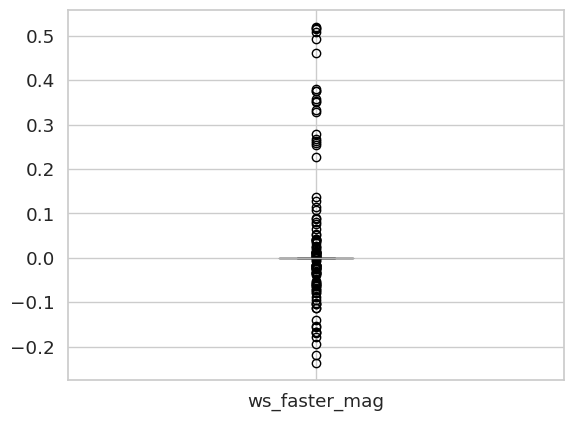

In [91]:
df_os_aux.boxplot(column="ws_faster_mag")

In [92]:
df_is_os_opt = pd.merge(df_is_aux,df_os_aux,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [93]:
df_is_os_opt

,simSeconds_pws_x,simTicks_x_x,finalTick_x_x,simFreq_x_x,hostSeconds_x_x,hostTickRate_x_x,hostMemory_x_x,simInsts_x_x,simOps_x_x,hostInstRate_x_x,...,cpu_type_y_y,aux_os_y_y,aux_ws_y_y,aux_is_y_y,prefer_ws_y_y,prefer_is_y,ws_faster_y,is_os_same,is_faster,ws_faster_mag_y
0,0.008590,8.589583e+09,8.589583e+09,1.000000e+12,80.56,106629916.0,681144.0,27193550.0,27867244.0,337577.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,134.86,92196734.0,681156.0,43355668.0,46031986.0,321486.0,...,ArmO3,NaN,13.0,0.0,True,True,False,True,False,0.000000
2,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,134.86,92196734.0,681156.0,43355668.0,46031986.0,321486.0,...,ArmO3,NaN,13.0,0.0,True,True,False,False,True,0.380192
3,0.010896,1.089598e+10,1.089598e+10,1.000000e+12,105.02,103754398.0,681152.0,32283689.0,32554942.0,307413.0,...,ArmO3,NaN,25.0,4.0,True,True,False,True,False,0.000000
4,0.019137,1.913669e+10,1.913669e+10,1.000000e+12,172.09,111201459.0,681148.0,50131047.0,51744393.0,291306.0,...,ArmO3,NaN,13.0,0.0,True,True,False,True,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.008755,8.755138e+09,8.755138e+09,1.000000e+12,72.86,120162878.0,681144.0,20041425.0,20313522.0,275065.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
396,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,847.00,68020100.0,681160.0,252236233.0,291913101.0,297799.0,...,ArmO3,NaN,5.0,0.0,True,True,True,False,False,-0.021594
397,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,847.00,68020100.0,681160.0,252236233.0,291913101.0,297799.0,...,ArmO3,NaN,5.0,0.0,True,True,False,True,False,0.000000
398,0.038848,3.884818e+10,3.884818e+10,1.000000e+12,545.10,71267912.0,681148.0,207837181.0,231011074.0,381282.0,...,ArmO3,NaN,5.0,0.0,True,True,False,True,False,0.000000


In [94]:
df_is_os_opt["os_speedup"] =  df_is_os_opt["simSeconds_pos"] / df_is_os_opt["simSeconds_pws_y"]

In [95]:
len(df_is_os_opt[df_is_os_opt["os_speedup"]>=1])/len(df_is_os_opt)

0.73

<Axes: >

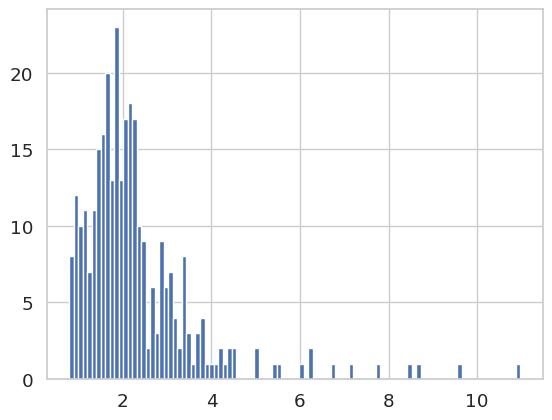

In [96]:
df_is_os_opt["os_speedup"].hist(bins = 100)

In [97]:
df_opt_bl = pd.merge(df_is_os_opt,df_bl_tp,how='left', left_on=['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters',], right_on = ['vector_length', 'num_bits','stride','filter_size','input_hw','num_filters'])

In [98]:
df_opt_bl

,simSeconds_pws_x,simTicks_x_x,finalTick_x_x,simFreq_x_x,hostSeconds_x_x,hostTickRate_x_x,hostMemory_x_x,simInsts_x_x,simOps_x_x,hostInstRate_x_x,...,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary,is_over_os,ws_over_os,ws_over_is
0,0.008590,8.589583e+09,8.589583e+09,1.000000e+12,80.56,106629916.0,681144.0,27193550.0,27867244.0,337577.0,...,14602669.0,16637376.0,os,0.013545,12820003.0,13974071.0,ws,4.180537,3.533786,0.845295
1,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,134.86,92196734.0,681156.0,43355668.0,46031986.0,321486.0,...,65148402.0,75099496.0,os,0.087809,61857544.0,66969039.0,ws,1.661908,6.849910,4.121714
2,0.012434,1.243365e+10,1.243365e+10,1.000000e+12,134.86,92196734.0,681156.0,43355668.0,46031986.0,321486.0,...,65148402.0,75099496.0,os,0.087809,61857544.0,66969039.0,ws,1.661908,6.849910,4.121714
3,0.010896,1.089598e+10,1.089598e+10,1.000000e+12,105.02,103754398.0,681152.0,32283689.0,32554942.0,307413.0,...,60315625.0,60587290.0,os,0.076688,57063262.0,57334839.0,ws,2.009631,7.385919,3.675261
4,0.019137,1.913669e+10,1.913669e+10,1.000000e+12,172.09,111201459.0,681148.0,50131047.0,51744393.0,291306.0,...,86625005.0,99062272.0,os,0.084596,78960163.0,85316407.0,ws,2.282176,6.038689,2.646023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.008755,8.755138e+09,8.755138e+09,1.000000e+12,72.86,120162878.0,681144.0,20041425.0,20313522.0,275065.0,...,74458846.0,74729969.0,os,0.080243,66902548.0,67173674.0,ws,2.659567,7.004452,2.633681
396,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,847.00,68020100.0,681160.0,252236233.0,291913101.0,297799.0,...,333052259.0,430123353.0,os,0.355337,319869459.0,368544554.0,ws,1.111415,4.540642,4.085460
397,0.057613,5.761312e+10,5.761312e+10,1.000000e+12,847.00,68020100.0,681160.0,252236233.0,291913101.0,297799.0,...,333052259.0,430123353.0,os,0.355337,319869459.0,368544554.0,ws,1.111415,4.540642,4.085460
398,0.038848,3.884818e+10,3.884818e+10,1.000000e+12,545.10,71267912.0,681148.0,207837181.0,231011074.0,381282.0,...,65142990.0,81184964.0,os,0.057760,61456501.0,69615596.0,ws,2.771548,2.436822,0.879228


In [99]:
df_bl_tp

,simSeconds_is,simInsts_is,simOps_is,vector_length,num_bits,stride,filter_size,anchoring_stationary_x,input_hw,num_filters,...,simInsts_os,simOps_os,anchoring_stationary_y,simSeconds_ws,simInsts_ws,simOps_ws,anchoring_stationary,is_over_os,ws_over_os,ws_over_is
0,0.017861,67827612.0,73104275.0,256,8,2,5,is,56,32,...,17734332.0,20372914.0,os,0.006335,17080178.0,18536617.0,ws,4.806512,1.704790,0.354683
1,0.008540,31154349.0,33411072.0,256,1,2,3,is,56,32,...,8803833.0,9957343.0,os,0.004044,7907847.0,8620925.0,ws,3.432476,1.625402,0.473536
2,0.004804,13702812.0,14784495.0,256,1,1,4,is,56,8,...,13433136.0,15225598.0,os,0.011012,12472358.0,13504604.0,ws,1.443510,3.308894,2.292256
3,0.025354,59709872.0,63867203.0,256,1,1,3,is,56,64,...,58213276.0,65454626.0,os,0.048583,50525610.0,54283168.0,ws,2.479366,4.750929,1.916187
4,0.064387,197878337.0,211455543.0,256,1,1,4,is,112,32,...,189695501.0,214973782.0,os,0.222222,174777531.0,187553428.0,ws,1.696985,5.856887,3.451349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.002639,8370379.0,9137945.0,256,8,2,3,is,56,8,...,3284963.0,3776576.0,os,0.001410,3062121.0,3443655.0,ws,2.061719,1.101562,0.534293
284,0.022904,51120183.0,51391760.0,128,1,1,3,is,112,16,...,49167118.0,49438791.0,os,0.053352,41638683.0,41910260.0,ws,2.313535,5.389091,2.329375
285,0.188082,310741427.0,311012522.0,128,8,1,5,is,112,64,...,432072062.0,432343156.0,os,0.510858,406092468.0,406363565.0,ws,3.104637,8.432644,2.716145
286,0.032718,99773118.0,106697268.0,256,1,1,4,is,112,16,...,95683002.0,108457971.0,os,0.111791,88223768.0,94747505.0,ws,1.673897,5.719380,3.416804


In [102]:
df_opt_bl["speedup over baseline os"] = df_opt_bl["simSeconds_os"] / df_opt_bl["simSeconds_pws_y"]
df_opt_bl["speedup over baseline ws"] = df_opt_bl["simSeconds_ws"] / df_opt_bl["simSeconds_pws_y"] 
df_opt_bl["speedup over baseline is"] = df_opt_bl["simSeconds_is"] / df_opt_bl["simSeconds_pws_y"]

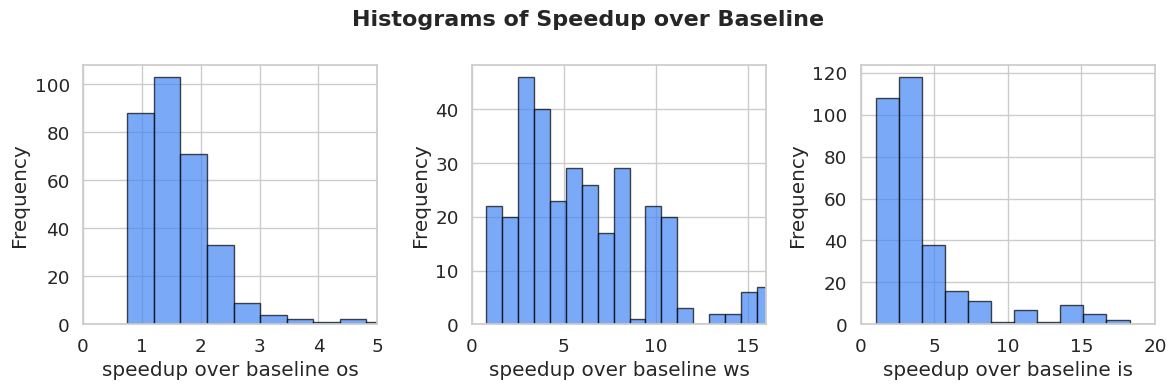

In [112]:
import matplotlib.pyplot as plt

# Define the columns for which you want to plot histograms
columns = ["speedup over baseline os", "speedup over baseline ws", "speedup over baseline is"]

# Define custom bins and x-axis limits for each column
bin_values = [20, 20, 20]
xlim_values = [(0, 5), (0, 16), (0, 20)]

# Create subplots for each column
fig, axes = plt.subplots(1, len(columns), figsize=(12, 4))

# Plot histograms for each column
for i, col in enumerate(columns):
    axes[i].hist(df_opt_bl[col], bins=bin_values[i], color='#4287f5', edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xlim(xlim_values[i])

# Set title for the overall plot
fig.suptitle("Histograms of Speedup over Baseline", fontsize=16, fontweight='bold')

# Adjust spacing between subplots
plt.tight_layout()



# Show the plot
plt.show()